<a href="https://colab.research.google.com/github/Tallivm/data_mining_notebooks/blob/main/Fish_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook uses some custom files which are automatically downloaded using wget commands

In [1]:
!rm fish.csv fish_test.csv pretty_plots.py
!wget -q 'https://raw.githubusercontent.com/VitaT/ML-python/main/data/fish.csv'
!wget -q 'https://raw.githubusercontent.com/Tallivm/custom_modules/main/pretty_plots.py'

rm: cannot remove 'fish.csv': No such file or directory
rm: cannot remove 'fish_test.csv': No such file or directory
rm: cannot remove 'pretty_plots.py': No such file or directory


In [2]:
import numpy as np
np.random.seed(42) # sklearn uses random state of numpy
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.neighbors import KNeighborsRegressor
from itertools import chain, combinations

import matplotlib.pyplot as plt
import pretty_plots as ppp

In [3]:
df = pd.read_csv('fish.csv')
print(ppp.txt_eff.BOLD + 'Missing values:' + ppp.txt_eff.END)
print(df.isna().sum().to_string())
print(ppp.txt_eff.BOLD + 'Types of data:' + ppp.txt_eff.END)
print(df.dtypes.to_string())
df.head(3)

Missing values:
Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
Types of data:
Species     object
Weight     float64
Length1    float64
Length2    float64
Length3    float64
Height     float64
Width      float64


,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961


# Regression

The data has a categorical column: **Species**. Dummies should be made.
k new columns will be made, where k is number of unique species in data.
We need k-1 columns, and usually the biggest group is dropped.

In [4]:
categorical = ['Species']
groups_to_drop = []
for col in categorical: 
  print(ppp.txt_eff.BOLD + f'{col}:' + ppp.txt_eff.END)
  [print(f'\t{item}: {len(df[df[col]==item])}') for item in df[col].unique()]
  largest_group = df.groupby(col).size().idxmax()
  groups_to_drop.append(col + '_' + largest_group)
  print(f'Largest group: {largest_group}')
xdata, ydata = df.drop(columns='Weight'), df['Weight']
xdata = pd.get_dummies(xdata, columns=categorical).drop(columns=groups_to_drop)
xdata.head(3)

Species:
	Bream: 31
	Roach: 19
	Whitefish: 6
	Parkki: 10
	Perch: 53
	Pike: 16
	Smelt: 12
Largest group: Perch


,Length1,Length2,Length3,Height,Width,Species_Bream,Species_Parkki,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
0,23.2,25.4,30.0,11.5200,4.0200,1,0,0,0,0,0
1,24.0,26.3,31.2,12.4800,4.3056,1,0,0,0,0,0
2,23.9,26.5,31.1,12.3778,4.6961,1,0,0,0,0,0


## Explore data

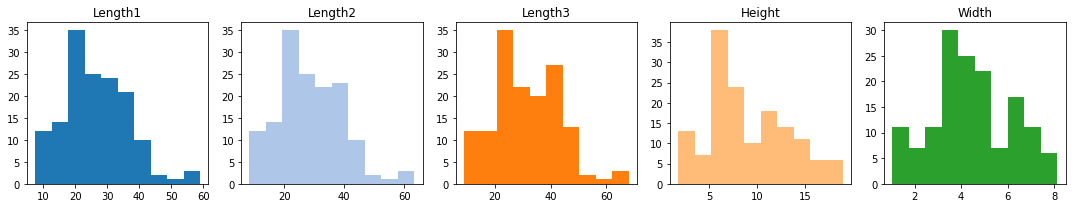

In [5]:
ppp.column_hists(xdata.drop(columns=[col for col in xdata.columns if any(col.startswith(x) for x in categorical)]))

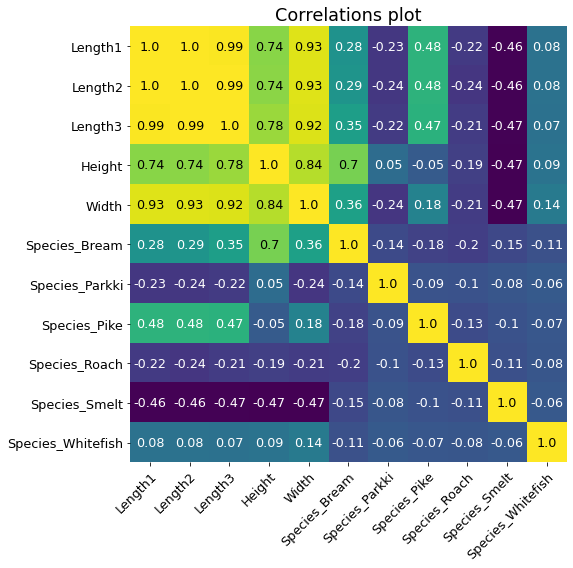

In [6]:
ppp.plot_corrs(xdata, method='spearman', plot_size=8)

*Length1*, *Length2*, *Length3* and *Width* are highly correlated. I will leave only *Length1* and *Width*.

In [7]:
xdata = xdata.drop(columns=['Length2', 'Length3'])

## Simple Linear Regression

Let's make it with *Length1*, *Height* and *Width* features.

In [8]:
get_scores = {'R-squared': 'r2', 
              'neg RMSE': 'neg_root_mean_squared_error'}

def score_cross_validation(model, x, y, scoring_dict,
                           cv=10, n_jobs=-1, return_estimator=False):
  results = cross_validate(model, x, y, cv=cv, n_jobs=n_jobs,
                            scoring=list(scoring_dict.values()),
                            return_estimator=return_estimator)
  chosen_results = []
  for score_name, scores in scoring_dict.items():
    biggest = max(results['test_'+scores])
    average = np.mean(results['test_'+scores])
    std = np.std(results['test_'+scores])
    chosen_results.extend([biggest, average, std])

  score_names = [[f'Max {name}', f'Mean {name}', f'Std {name}'] for name in scoring_dict.keys()]
  score_names = list(chain(*score_names))

  return chosen_results, score_names

In [9]:
xdatas = [xdata[[col]] for col in ['Length1', 'Height', 'Width']]
model = linear_model.LinearRegression()
kf =  KFold(n_splits=10, shuffle=True, random_state=42)

for x in xdatas:
  res, scr = score_cross_validation(model, x, ydata, get_scores, cv=kf)
  ppp.rank_results([res], [f'Simple Linear Regression: {x.columns.values}'], scr, main_score_id=1, round_by=3)

Simple Linear Regression: ['Length1']
Max R-squared: 0.893
Mean R-squared: 0.806
Std R-squared: 0.068
Max neg RMSE: -89.419
Mean neg RMSE: -144.196
Std neg RMSE: 25.183
----------
Simple Linear Regression: ['Height']
Max R-squared: 0.770
Mean R-squared: 0.492
Std R-squared: 0.170
Max neg RMSE: -159.995
Mean neg RMSE: -241.127
Std neg RMSE: 78.461
----------
Simple Linear Regression: ['Width']
Max R-squared: 0.894
Mean R-squared: 0.759
Std R-squared: 0.107
Max neg RMSE: -96.919
Mean neg RMSE: -163.069
Std neg RMSE: 55.270
----------


##Multivariative Linear Regression

Let's try it with different feature sets


In [10]:
model = linear_model.LinearRegression()

xdatas = [xdata[['Length1', 'Height', 'Width']], 
          xdata[['Height', 'Width']],
          xdata[['Length1', 'Width']],
          xdata,
          xdata.drop(columns=['Species_Smelt', 'Species_Pike'])]

for x in xdatas:
  res, scr = score_cross_validation(model, x, ydata, get_scores, cv=kf)
  ppp.rank_results([res], [f'Multivariative Linear Regression: {x.columns.values}'], scr, main_score_id=1, round_by=3)

Multivariative Linear Regression: ['Length1' 'Height' 'Width']
Max R-squared: 0.912
Mean R-squared: 0.858
Std R-squared: 0.035
Max neg RMSE: -101.504
Mean neg RMSE: -125.434
Std neg RMSE: 23.495
----------
Multivariative Linear Regression: ['Height' 'Width']
Max R-squared: 0.890
Mean R-squared: 0.760
Std R-squared: 0.109
Max neg RMSE: -98.528
Mean neg RMSE: -162.907
Std neg RMSE: 57.747
----------
Multivariative Linear Regression: ['Length1' 'Width']
Max R-squared: 0.898
Mean R-squared: 0.845
Std R-squared: 0.046
Max neg RMSE: -104.229
Mean neg RMSE: -130.184
Std neg RMSE: 22.946
----------
Multivariative Linear Regression: ['Length1' 'Height' 'Width' 'Species_Bream' 'Species_Parkki'
 'Species_Pike' 'Species_Roach' 'Species_Smelt' 'Species_Whitefish']
Max R-squared: 0.949
Mean R-squared: 0.915
Std R-squared: 0.023
Max neg RMSE: -65.035
Mean neg RMSE: -98.946
Std neg RMSE: 28.621
----------
Multivariative Linear Regression: ['Length1' 'Height' 'Width' 'Species_Bream' 'Species_Parkki'
 '

Model with all selected features got the best result. R-squared of 0.91 is a pretty nice result. Let's try more difficult models.

## Ridge Regression

In [11]:
ridge_models = []
for a in np.logspace(-3, 3, 7):
  ridge_models.append([a, linear_model.Ridge(alpha=a)])

for (a, model) in ridge_models:
  res, scr = score_cross_validation(model, xdata, ydata, get_scores, cv=kf)
  ppp.rank_results([res], [f'Ridge Regression (alpha={a})'], scr, 
                   main_score_id=1, round_by=5)

Ridge Regression (alpha=0.001)
Max R-squared: 0.94876
Mean R-squared: 0.91498
Std R-squared: 0.02303
Max neg RMSE: -65.03639
Mean neg RMSE: -98.94294
Std neg RMSE: 28.62169
----------
Ridge Regression (alpha=0.01)
Max R-squared: 0.94874
Mean R-squared: 0.91503
Std R-squared: 0.02301
Max neg RMSE: -65.05248
Mean neg RMSE: -98.91641
Std neg RMSE: 28.62694
----------
Ridge Regression (alpha=0.1)
Max R-squared: 0.94847
Mean R-squared: 0.91544
Std R-squared: 0.02289
Max neg RMSE: -65.19866
Mean neg RMSE: -98.70105
Std neg RMSE: 28.68342
----------
Ridge Regression (alpha=1.0)
Max R-squared: 0.94463
Mean R-squared: 0.91544
Std R-squared: 0.02299
Max neg RMSE: -66.41393
Mean neg RMSE: -98.67718
Std neg RMSE: 28.96011
----------
Ridge Regression (alpha=10.0)
Max R-squared: 0.94055
Mean R-squared: 0.89520
Std R-squared: 0.02362
Max neg RMSE: -79.51218
Mean neg RMSE: -108.94337
Std neg RMSE: 26.33827
----------
Ridge Regression (alpha=100.0)
Max R-squared: 0.92098
Mean R-squared: 0.86424
Std R-s

The best alpha is somewhere between 0.1 and 1.

In [12]:
ridge_models = []
for a in [.1, .3, .5, .7, .9]:
  ridge_models.append([a, linear_model.Ridge(alpha=a)])

for (a, model) in ridge_models:
  res, scr = score_cross_validation(model, xdata, ydata, get_scores, cv=kf)
  ppp.rank_results([res], [f'Ridge Regression (alpha={a})'], scr, 
                   main_score_id=1, round_by=5)

Ridge Regression (alpha=0.1)
Max R-squared: 0.94847
Mean R-squared: 0.91544
Std R-squared: 0.02289
Max neg RMSE: -65.19866
Mean neg RMSE: -98.70105
Std neg RMSE: 28.68342
----------
Ridge Regression (alpha=0.3)
Max R-squared: 0.94777
Mean R-squared: 0.91591
Std R-squared: 0.02281
Max neg RMSE: -65.47185
Mean neg RMSE: -98.45221
Std neg RMSE: 28.80215
----------
Ridge Regression (alpha=0.5)
Max R-squared: 0.94695
Mean R-squared: 0.91600
Std R-squared: 0.02285
Max neg RMSE: -65.72676
Mean neg RMSE: -98.39644
Std neg RMSE: 28.88728
----------
Ridge Regression (alpha=0.7)
Max R-squared: 0.94606
Mean R-squared: 0.91587
Std R-squared: 0.02291
Max neg RMSE: -65.98953
Mean neg RMSE: -98.45602
Std neg RMSE: 28.93746
----------
Ridge Regression (alpha=0.9)
Max R-squared: 0.94511
Mean R-squared: 0.91561
Std R-squared: 0.02297
Max neg RMSE: -66.26817
Mean neg RMSE: -98.59013
Std neg RMSE: 28.95853
----------


## Lasso Regression

In [13]:
lasso_models = []
for a in np.logspace(-2, 2, 5):
  lasso_models.append([a, linear_model.Lasso(alpha=a)])

for a in [.05, .3, .5, .7, .9]:
  lasso_models.append([a, linear_model.Lasso(alpha=a)])

for (a, model) in sorted(lasso_models, key=lambda x: x[0]):
  res, scr = score_cross_validation(model, xdata, ydata, get_scores, cv=kf)
  ppp.rank_results([res], [f'Ridge Regression (alpha={a})'], scr, 
                   main_score_id=1, round_by=5)

Ridge Regression (alpha=0.01)
Max R-squared: 0.94880
Mean R-squared: 0.91507
Std R-squared: 0.02305
Max neg RMSE: -64.90473
Mean neg RMSE: -98.89089
Std neg RMSE: 28.62511
----------
Ridge Regression (alpha=0.05)
Max R-squared: 0.94892
Mean R-squared: 0.91543
Std R-squared: 0.02315
Max neg RMSE: -64.39234
Mean neg RMSE: -98.67965
Std neg RMSE: 28.64565
----------
Ridge Regression (alpha=0.1)
Max R-squared: 0.94902
Mean R-squared: 0.91570
Std R-squared: 0.02324
Max neg RMSE: -64.03196
Mean neg RMSE: -98.51401
Std neg RMSE: 28.65778
----------
Ridge Regression (alpha=0.3)
Max R-squared: 0.94920
Mean R-squared: 0.91622
Std R-squared: 0.02337
Max neg RMSE: -63.79193
Mean neg RMSE: -98.16632
Std neg RMSE: 28.58276
----------
Ridge Regression (alpha=0.5)
Max R-squared: 0.94832
Mean R-squared: 0.91630
Std R-squared: 0.02329
Max neg RMSE: -63.71785
Mean neg RMSE: -98.10305
Std neg RMSE: 28.45037
----------
Ridge Regression (alpha=0.7)
Max R-squared: 0.94705
Mean R-squared: 0.91620
Std R-square

## KNN

In [14]:
knn_models = []
for n in range(1, 5):
  for p in [1,2]:
    knn_models.append([n, p, KNeighborsRegressor(n_neighbors=n, p=p)])

for (n, p, model) in sorted(knn_models, key=lambda x: x[0]):
  res, scr = score_cross_validation(model, xdata, ydata, get_scores, cv=kf)
  ppp.rank_results([res], [f'KNN (n_neighbors={n}, p={p})'], scr, 
                   main_score_id=1, round_by=3)

KNN (n_neighbors=1, p=1)
Max R-squared: 0.994
Mean R-squared: 0.964
Std R-squared: 0.020
Max neg RMSE: -18.929
Mean neg RMSE: -61.671
Std neg RMSE: 22.408
----------
KNN (n_neighbors=1, p=2)
Max R-squared: 0.994
Mean R-squared: 0.966
Std R-squared: 0.018
Max neg RMSE: -18.929
Mean neg RMSE: -60.096
Std neg RMSE: 21.053
----------
KNN (n_neighbors=2, p=1)
Max R-squared: 0.991
Mean R-squared: 0.976
Std R-squared: 0.010
Max neg RMSE: -24.245
Mean neg RMSE: -50.698
Std neg RMSE: 13.727
----------
KNN (n_neighbors=2, p=2)
Max R-squared: 0.993
Mean R-squared: 0.979
Std R-squared: 0.011
Max neg RMSE: -24.983
Mean neg RMSE: -46.613
Std neg RMSE: 13.200
----------
KNN (n_neighbors=3, p=1)
Max R-squared: 0.990
Mean R-squared: 0.974
Std R-squared: 0.012
Max neg RMSE: -34.632
Mean neg RMSE: -53.490
Std neg RMSE: 17.097
----------
KNN (n_neighbors=3, p=2)
Max R-squared: 0.992
Mean R-squared: 0.975
Std R-squared: 0.013
Max neg RMSE: -22.027
Mean neg RMSE: -51.547
Std neg RMSE: 19.668
----------
KNN 

It can be seen that KNN with 2 neighbors and default Euclidean metric results in even better mean R-squared score: ~0.98

## Best Regression model

Used features:
	Length1
	Height
	Width
	Species_Bream
	Species_Parkki
	Species_Pike
	Species_Roach
	Species_Smelt
	Species_Whitefish


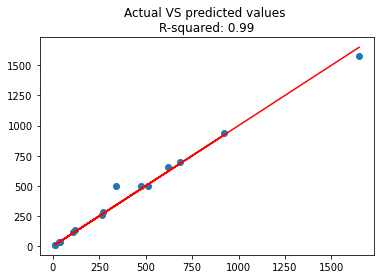

In [15]:
print(ppp.txt_eff.BOLD + 'Used features:' + ppp.txt_eff.END)
for col in xdata.columns: print(f'\t{col}')

model = KNeighborsRegressor(n_neighbors=2, p=2)
xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, test_size=.1,
                                                random_state=42)
model.fit(xtrain, ytrain)
yhat = model.predict(xtest)
plt.scatter(ytest, yhat)
plt.plot(ytest, ytest, c='r')
plt.title(f'Actual VS predicted values \nR-squared: {round(r2_score(ytest, yhat), 2)}')
plt.show()

###Check on other test set

In [16]:
!wget -q 'https://raw.githubusercontent.com/VitaT/ML-python/main/data/fish_test.csv'

In [17]:
test_data = pd.read_csv('fish_test.csv').drop(columns=['Unnamed: 0', 'Length2', 'Length3'])
test_x, test_y = test_data.drop(columns=['Weight']), test_data['Weight']
test_x = pd.get_dummies(test_x, columns=categorical).drop(columns=groups_to_drop)
len(xdata.columns), len(test_x.columns)

(9, 8)

"Repair" the test set

In [18]:
for col in xdata.columns: 
  if col not in test_x.columns: 
    print(col)

Species_Pike


In [19]:
test_x['Species_Pike'] = 0
test_x = test_x.reindex(columns=xdata.columns)
list(zip(xdata.columns, test_x.columns))

[('Length1', 'Length1'),
 ('Height', 'Height'),
 ('Width', 'Width'),
 ('Species_Bream', 'Species_Bream'),
 ('Species_Parkki', 'Species_Parkki'),
 ('Species_Pike', 'Species_Pike'),
 ('Species_Roach', 'Species_Roach'),
 ('Species_Smelt', 'Species_Smelt'),
 ('Species_Whitefish', 'Species_Whitefish')]

Now run the model

Used features:
	Length1
	Height
	Width
	Species_Bream
	Species_Parkki
	Species_Pike
	Species_Roach
	Species_Smelt
	Species_Whitefish


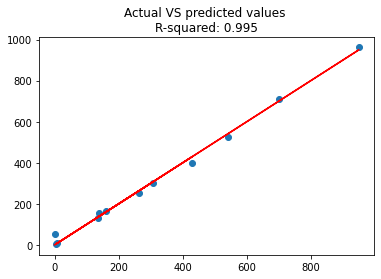

In [20]:
print(ppp.txt_eff.BOLD + 'Used features:' + ppp.txt_eff.END)
for col in test_x.columns: print(f'\t{col}')

yhat = model.predict(test_x)
plt.scatter(test_y, yhat)
plt.plot(test_y, test_y, c='r')
plt.title(f'Actual VS predicted values \nR-squared: {round(r2_score(test_y, yhat), 3)}')
plt.show()

# Classification

Convert *Species* column to integers to prepare for multiclass classification.

In [21]:
from sklearn.linear_model import RidgeClassifier
from sklearn import svm, tree
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import multilabel_confusion_matrix, classification_report

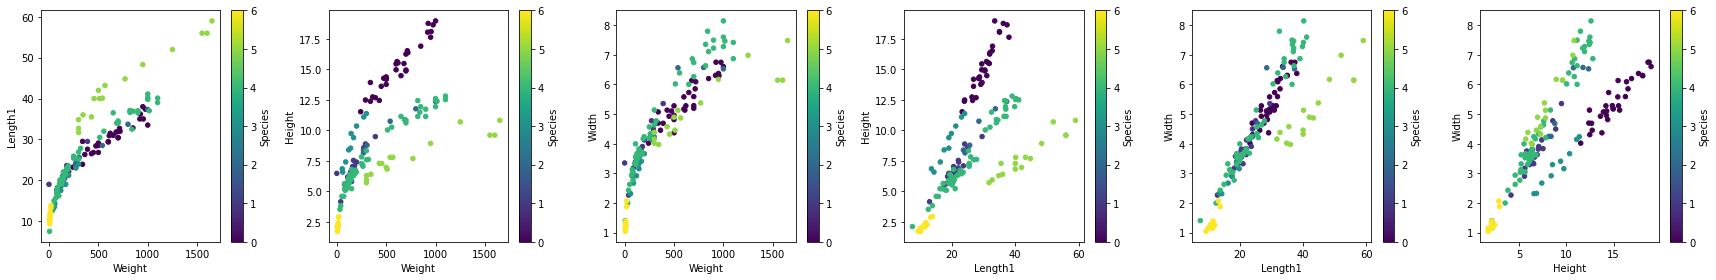

In [22]:
df['Species'], species_names = pd.factorize(df['Species'])

pairs = list(combinations(df.drop(columns=['Species', 'Length2', 'Length3']).columns, 2))
fig, axs = plt.subplots(1, len(pairs), figsize=(4*len(pairs), 4))
for n, pair in enumerate(pairs):
  df.plot.scatter(pair[0], pair[1], c='Species', colormap='viridis', ax=axs[n])
plt.tight_layout()
plt.show()

It can be seen from these plots that *Height* feature really helps to differentiate between *Species*.

In [23]:
y = df['Species']
x = df.drop(columns=['Species', 'Length2', 'Length3'])

## Try some Classification models

In [24]:
models = {'Ridge Classifier (alpha=1)': RidgeClassifier(alpha=1),
          'Ridge Classifier (alpha=.1)': RidgeClassifier(alpha=.1),
          'KN Classifier (nn=5)': KNeighborsClassifier(n_neighbors=5),
          'KN Classifier (nn=2)': KNeighborsClassifier(n_neighbors=2),
          'Nearest Centroid': NearestCentroid(),
          'Support Machine Vectors': svm.SVC(),
          'Decision Trees': tree.DecisionTreeClassifier()}

kf =  StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

class_score = {'F1': 'f1_macro',
               'Accuracy': 'accuracy'}
for name, model in models.items():
  res, scr = score_cross_validation(model, x, y, class_score, cv=kf)
  ppp.rank_results([res], [f'{name}'], scr, 
                   main_score_id=1, round_by=3)

Ridge Classifier (alpha=1)
Max F1: 0.522
Mean F1: 0.501
Std F1: 0.012
Max Accuracy: 0.759
Mean Accuracy: 0.742
Std Accuracy: 0.014
----------
Ridge Classifier (alpha=.1)
Max F1: 0.522
Mean F1: 0.501
Std F1: 0.012
Max Accuracy: 0.759
Mean Accuracy: 0.742
Std Accuracy: 0.014
----------
KN Classifier (nn=5)
Max F1: 0.466
Mean F1: 0.373
Std F1: 0.074
Max Accuracy: 0.633
Mean Accuracy: 0.488
Std Accuracy: 0.109
----------
KN Classifier (nn=2)
Max F1: 0.543
Mean F1: 0.401
Std F1: 0.075
Max Accuracy: 0.600
Mean Accuracy: 0.441
Std Accuracy: 0.082
----------
Nearest Centroid
Max F1: 0.388
Mean F1: 0.260
Std F1: 0.066
Max Accuracy: 0.345
Mean Accuracy: 0.266
Std Accuracy: 0.047
----------
Support Machine Vectors
Max F1: 0.253
Mean F1: 0.208
Std F1: 0.044
Max Accuracy: 0.517
Mean Accuracy: 0.463
Std Accuracy: 0.033
----------
Decision Trees
Max F1: 0.761
Mean F1: 0.679
Std F1: 0.078
Max Accuracy: 0.733
Mean Accuracy: 0.687
Std Accuracy: 0.043
----------


## Tuning of Decision Trees by AUC

Let's concentrate on Decision Trees as a fast methd showing nice results

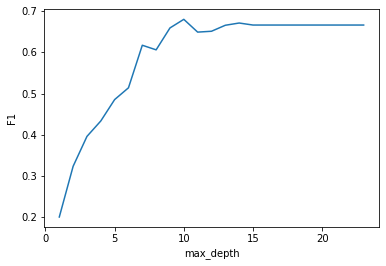

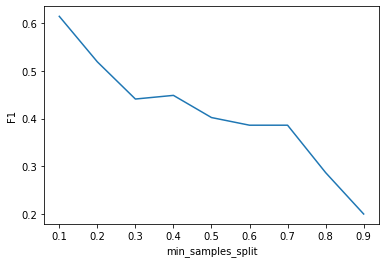

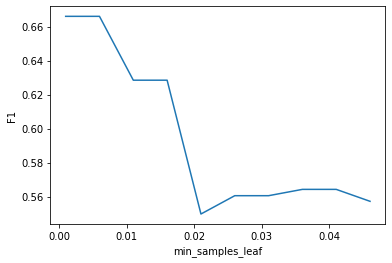

In [25]:
class_score = {'AUC': 'roc_auc_ovo',
               'F1': 'f1_macro',
               'Accuracy': 'accuracy',
               }

max_depths = range(1, 24)
auc_res = []

for m in max_depths:
  model = tree.DecisionTreeClassifier(max_depth=m, random_state=42)
  res = cross_validate(model, x, y, scoring=class_score, cv=kf)
  auc_res.append(np.mean(res['test_F1']))

plt.plot(max_depths, auc_res)
plt.xlabel('max_depth'), plt.ylabel('F1')
plt.show()

#-----------------------

min_samples_split = [x*.1 for x in range(1, 10)]
auc_res = []

for m in min_samples_split:
  model = tree.DecisionTreeClassifier(min_samples_split=m, random_state=42)
  res = cross_validate(model, x, y, scoring=class_score, cv=kf)
  auc_res.append(np.mean(res['test_F1']))

plt.plot(min_samples_split, auc_res)
plt.xlabel('min_samples_split'), plt.ylabel('F1')
plt.show()

#-----------------------
min_samples_leafs = [x*.001 for x in range(1, 50, 5)]
auc_res = []

for m in min_samples_leafs:
  model = tree.DecisionTreeClassifier(min_samples_leaf=m, random_state=42)
  res = cross_validate(model, x, y, scoring=class_score, cv=kf)
  auc_res.append(np.mean(res['test_F1']))

plt.plot(min_samples_leafs, auc_res)
plt.xlabel('min_samples_leaf'), plt.ylabel('F1')
plt.show()


As we can see on this plot:
 * *max_depth* hyperparameter should be around 10 for best results
 * *min_samples_split* should be around .1
 * *min_samples_leafs* should be small, .001-.005

In [26]:
model = tree.DecisionTreeClassifier(max_depth=10,
                                    min_samples_split=.1, 
                                    min_samples_leaf=.001,
                                    random_state=42)

res, scr = score_cross_validation(model, x, y, class_score, cv=kf)
ppp.rank_results([res], [f'Tuned Decision Trees'], scr, 
                 main_score_id=1, round_by=3)

Tuned Decision Trees
Max AUC: 0.927
Mean AUC: 0.857
Std AUC: 0.052
Max F1: 0.709
Mean F1: 0.614
Std F1: 0.076
Max Accuracy: 0.767
Mean Accuracy: 0.687
Std Accuracy: 0.083
----------


Let's also try to tune it with Grid Search CV.

Tuned Decision Tree hyperparameters:  {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 0.003, 'min_samples_split': 0.1}
Tuned Decision Tree F1:  0.7071264367816092


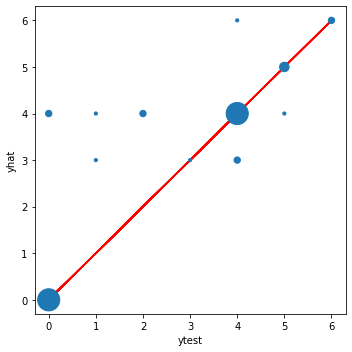

In [27]:
hyperparams = {'max_depth': list(range(5,15)),
               'min_samples_split': [.1,.2,.3,.4],
               'min_samples_leaf': [x*.001 for x in range(1,5)],
               "criterion": ["gini", "entropy"]}
kf =  StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(tree.DecisionTreeClassifier(), hyperparams, cv=kf, scoring='f1_micro')
grid.fit(x, y)
print(ppp.txt_eff.BOLD + f'Tuned Decision Tree hyperparameters: {ppp.txt_eff.END} {grid.best_params_}')
print(ppp.txt_eff.BOLD + f'Tuned Decision Tree F1: {ppp.txt_eff.END} {grid.best_score_}')

model = tree.DecisionTreeClassifier(**grid.best_params_, random_state=42)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=.2,
                                                random_state=42)
model.fit(xtrain, ytrain)
yhat = model.predict(xtest)

t = pd.DataFrame({'ytest':ytest, 'yhat':yhat})
t = t.groupby(['ytest','yhat']).size().reset_index(name='count')
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(ytest, ytest, c='r', zorder=1)
t.plot.scatter('ytest', 'yhat', s=10*t['count']**2, ax=ax, zorder=2)
plt.tight_layout()
plt.show()

In [28]:
l_ints = list(range(0,7))
all_counts = df['Species'].value_counts(sort=False)
report = classification_report(ytest, yhat, 
                            labels=l_ints,
                            zero_division=0,
                            output_dict=True)
report = pd.DataFrame.from_dict(report).T.iloc[:7,:]
report.index = l_ints
report['All true count'] = all_counts
report['Test true count'] = pd.Series(ytest).value_counts(sort=False)
report['Test predicted count'] = pd.Series(yhat).value_counts(sort=False)
report['Test predicted count'] = report['Test predicted count'].fillna(0).astype(int)
report.index = species_names
report

,precision,recall,f1-score,support,All true count,Test true count,Test predicted count
Bream,1.000000,0.777778,0.875000,9.0,31,9,7
Roach,0.000000,0.000000,0.000000,2.0,19,2,0
Whitefish,0.000000,0.000000,0.000000,2.0,6,2,0
Parkki,0.250000,1.000000,0.400000,1.0,10,1,4
Perch,0.538462,0.700000,0.608696,10.0,53,10,13
Pike,1.000000,0.750000,0.857143,4.0,16,4,3
Smelt,0.666667,1.000000,0.800000,2.0,12,2,3


In [29]:
t[['ytest','yhat']] = t[['ytest','yhat']].replace(dict(zip(l_ints, species_names)))
t.sort_values('ytest')

,ytest,yhat,count
0,Bream,Bream,7
1,Bream,Perch,2
5,Parkki,Parkki,1
6,Perch,Parkki,2
7,Perch,Perch,7
8,Perch,Smelt,1
9,Pike,Perch,1
10,Pike,Pike,3
2,Roach,Parkki,1
3,Roach,Perch,1


We found our only Parkki and both Smelts. We also found none of Roach or Whitefich species - they were labaled either as Perches or Parkki. All found Breams and Pikes are truly Breams and Pikes, but some of them were missslassified as Perches. Seems that model favors Perches, because it is the largest class in data.